In [14]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.18.0
Eager mode:  True
Hub version:  0.16.1
GPU is NOT AVAILABLE


In [15]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

In [16]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 25000, test entries: 25000


In [17]:
train_examples[:10]

array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot 

In [18]:
train_labels[:10]

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Decode byte strings
train_examples = [example.decode('utf-8') for example in train_examples]
test_examples = [example.decode('utf-8') for example in test_examples]

# Tokenize the text
tokenizer = Tokenizer(num_words=10000)  # Limit the vocabulary size
tokenizer.fit_on_texts(train_examples)

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_examples)
test_sequences = tokenizer.texts_to_sequences(test_examples)

# Pad sequences to have the same length
max_length = 100  # Choose an appropriate max length for padding
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [20]:
train_padded[:3]

array([[1365, 3584,   39,  485,  196,   23,   84,  153,   18,   11,  212,
         328,   27,   65,  246,  214,    8,  476,   57,   65,   84,  113,
          97,   21, 5674,   11, 1321,  642,  766,   11,   17,    6,   32,
         399, 8169,  175, 2454,  415,    1,   88, 1230,  136,   68,  145,
          51,    1, 7576,   68,  228,   65, 2932,   15, 2903, 1478, 4939,
           2,   38, 3899,  116, 1583,   16, 3584,   13,  161,   18,    3,
        1230,  916, 7916,    8,    3,   17,   12,   13, 4138,    4,   98,
         144, 1213,   10,  241,  682,   12,   47,   23,   99,   37,   11,
        7180, 5514,   37, 1365,   49,  400,   10,   97, 1196,  866,  140,
           9],
       [  11,    6,  628,  685,    5,    3, 2218,    4,  180,  583,   63,
        1453,  109, 2262,    2, 3950,   20,    1,    2,  257,   40, 4676,
           3,  173,  187,   20,   11, 4077,   10, 1577, 2353,   85,    1,
          19,   13, 1906,    1,  111,  939,   13, 1810, 1339,  547,    2,
         354,  180,  46

In [21]:
vocab_size = len(tokenizer.word_index)
print(vocab_size) 

88582


In [22]:
# HUOM!!!
# Chat GPT when asked what to do if not being able to use hub_layers

import numpy as np
import tensorflow as tf

# Assuming you already have tokenizer and max_length defined
vocab_size = len(tokenizer.word_index) + 1  # Include padding token
embedding_dim = 50  # Use GloVe embedding dimension

# Load GloVe embeddings
embedding_index = {}
with open('glove.6B.50d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefficients

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Define model with pretrained embeddings
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=vocab_size,
                                     output_dim=embedding_dim,
                                     weights=[embedding_matrix],
                                     input_length=max_length,
                                     trainable=False))  # Set trainable=False to freeze embeddings
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.build(input_shape=(None, max_length))
model.summary()

u:\Users\jk026110\tekstianalyysi\env\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 50)        │     4,429,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        58,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,490,111 (17.13 MB)

 Trainable params: 60,961 (238.13 KB)

 Non-trainable params: 4,429,150 (16.90 MB)

In [23]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [24]:
# x_val = train_examples[:10000]
# partial_x_train = train_examples[10000:]

# y_val = train_labels[:10000]
# partial_y_train = train_labels[10000:]

x_val = train_padded[:10000]
partial_x_train = train_padded[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [25]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 463ms/step - accuracy: 0.5506 - loss: 0.6817 - val_accuracy: 0.6753 - val_loss: 0.6192
Epoch 2/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 423ms/step - accuracy: 0.7032 - loss: 0.5801 - val_accuracy: 0.7231 - val_loss: 0.5500
Epoch 3/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 427ms/step - accuracy: 0.7348 - loss: 0.5339 - val_accuracy: 0.7347 - val_loss: 0.5473
Epoch 4/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 490ms/step - accuracy: 0.7475 - loss: 0.5132 - val_accuracy: 0.7506 - val_loss: 0.5071
Epoch 5/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 477ms/step - accuracy: 0.7577 - loss: 0.4963 - val_accuracy: 0.7590 - val_loss: 0.4943
Epoch 6/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 456ms/step - accuracy: 0.7756 - loss: 0.4747 - val_accuracy: 0.7683 - val_loss: 0.4838
Epoch 7/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step - accuracy: 0.7747 - loss: 0.4723 - val_accuracy: 0.7739 - val_loss: 0.4703
Epoch 8/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - accuracy: 0.7788 - loss: 0.4641 - val_accura

In [38]:
test_padded[:1]

array([[   2,   57,   92,   10,   89,  101,   10, 1497,  176,   11,  251,
          35,    5, 1125,  673,    6, 4386,    3,  326,    6,   35, 8299,
         365,    4, 1402,   12,   28,   59,   25,    5,  866,  177,   16,
           3, 1036,    4,   11,  226,    2,   78,    3,  344,   31,  344,
        5158,    4,    9,    5, 1313, 1142,    1, 5618,    2,    4,    9,
         172,  321,    6, 1292, 3937,    3,  787, 1908,    4,    3,  249,
        2672,  164,    2,    1,  351,   29,  184,   23, 1153,  222,  598,
           4,    1,  117,    1,  347, 1381, 7674,   28,  870,   36,    3,
          19,   37,   11,    3,  326,    6,    3,   19,  623,   55,   45,
         213]], dtype=int32)

In [27]:
test_labels[:10]

array([1, 1, 0, 0, 1, 1, 1, 1, 0, 1])

In [ ]:
results = model.evaluate(test_padded, test_labels)

moh=model.predict(test_padded)

print(moh[:10])

782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7821 - loss: 0.5528
[0.5381254553794861, 0.788919985294342]


782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.7821 - loss: 0.5528
  1/782 ━━━━━━━━━━━━━━━━━━━━ 19:11 1s/step

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

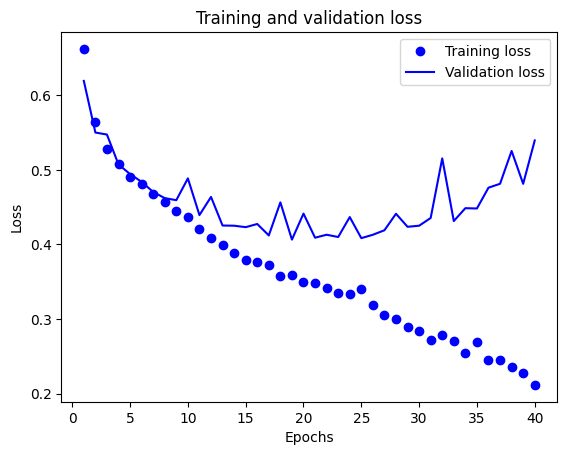

In [30]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

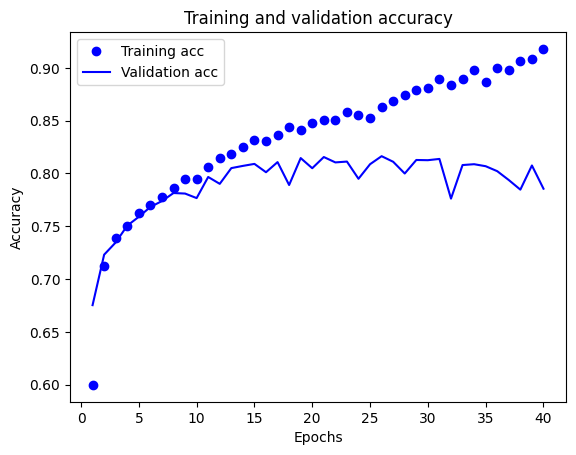

In [31]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [32]:
# test_examples

In [33]:
test_labels

array([1, 1, 0, ..., 0, 1, 1])

In [ ]:
# Use the model to predict unseen test set and compare the results to known true labels
# assigning predicted values (argmax used to convert one-hot back to int)
#predicted = np.argmax(model.predict(test_examples), axis = 1)
#truevalue = np.argmax(test_labels, axis = 1)

predicted = model.predict(test_padded)

In [ ]:
predicted

NameError: name 'predicted' is not defined

In [ ]:
min(predicted)

NameError: name 'predicted' is not defined

In [ ]:
max(predicted)

In [ ]:
y_pred_binary = (predicted > 0).astype("float32")
y_pred_binary

NameError: name 'predicted' is not defined

In [ ]:
print(test_examples[0])
print(test_examples[1])
print(test_examples[2])
print(test_examples[3])
print(test_examples[4])
print(test_labels[0:5])
print(predicted[0:5])
print(y_pred_binary[0:5])

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Example: First few true labels and predictions
print("Test Labels:", test_labels)
print("Predicted Probabilities:", predicted)  # If using probabilities
print("Binary Predictions:", y_pred_binary)

# Generate confusion matrix
cm = confusion_matrix(test_labels, y_pred_binary)

# Print confusion matrix
print("Confusion Matrix:\n", cm)

# Optional: Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_labels))
disp.plot(cmap='Blues')

ModuleNotFoundError: No module named 'sklearn'